# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

# Import and rework data

In [2]:
# import stock data 

#define yesterday 

yesterday = dt.date.today()

last_5_years = dt.date.today() - dt.timedelta(days=1825)

tickers = [
'CNDX.L',
'CMOP.L',
'BTC-GBP']

# use a for loop to fetch the "Close" price data for each ticker
dfs = []
for ticker in tickers:
    t = yf.Ticker(ticker)
    data = t.history(start=last_5_years, end=yesterday)
    data = pd.DataFrame(data['Close'])
    data.columns = [ticker]
    data.index = data.index.strftime('%Y-%m-%d')
    dfs.append(data)

# Merge dataframes using index date
df = dfs[0]
for i in range(1, len(dfs)):
    df = pd.merge(df, dfs[i], how='outer', left_index=True, right_index=True)

# Rename the columns with the tickers
df.columns = tickers

df.head(5)

,CNDX.L,CMOP.L,BTC-GBP
Date,,,
2018-04-01,NaN,NaN,4876.196777
2018-04-02,NaN,NaN,5043.645508
2018-04-03,357.390015,1263.0,5300.426270
2018-04-04,357.589996,1249.5,4865.365234
2018-04-05,367.730011,1266.0,4863.598633


In [3]:
df.isnull().sum()

CNDX.L     562
CMOP.L     562
BTC-GBP      0
dtype: int64

In [4]:
# fill all empty values with data

df = df.dropna()

df.isnull().sum()

CNDX.L     0
CMOP.L     0
BTC-GBP    0
dtype: int64

# Define allocations

In [5]:
# define allocation to each ticker 

allocations = {'CNDX.L': 0.53737,
               'CMOP.L': 0.36195, 
               'BTC-GBP': 0.10068}

#remove null values 

df.shape


(1263, 3)

# Continue building the dataset

In [6]:
# remove null values 

df = df.dropna()

df.shape

(1263, 3)

In [7]:
# calculate the allocation-weighted returns for each ticker
returns = df.pct_change()

weighted_returns = returns.mul(list(allocations.values()))

# calculate the total portfolio returns
portfolio_returns = weighted_returns.sum(axis=1)

# print the last 5 values of the portfolio returns
df['portfolio_returns'] = portfolio_returns

df.tail()

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns
Date,,,,
2023-03-24,718.880005,1804.25,23071.191406,-0.002452
2023-03-27,722.929993,1805.75,22861.289062,0.002412
2023-03-28,714.494995,1816.50,22070.970703,-0.007596
2023-03-29,725.765015,1817.50,22114.345703,0.008873
2023-03-30,735.960022,1811.00,23028.177734,0.010415


In [8]:
# define a dictionary with asset class by ticker 

asset_class = {
               'CNDX.L': 'equity', 
               'CMOP.L': 'commodity', 
               'BTC-GBP': 'bitcoin'}

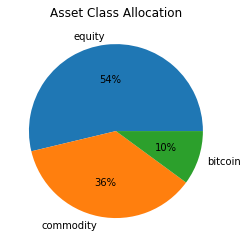

In [9]:
# calculate the allocation by asset class
asset_class_allocations = {}
for ticker, allocation in allocations.items():
    ac = asset_class[ticker]
    if ac in asset_class_allocations:
        asset_class_allocations[ac] += allocation
    else:
        asset_class_allocations[ac] = allocation

# plot the allocation by asset class
labels = list(asset_class_allocations.keys())
sizes = list(asset_class_allocations.values())
plt.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Asset Class Allocation')
plt.show()

In [10]:
df.tail(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns
Date,,,,
2023-03-29,725.765015,1817.5,22114.345703,0.008873
2023-03-30,735.960022,1811.0,23028.177734,0.010415


In [11]:
# define ticker currency

ticker_currency = {
               'CNDX.L': 'USD', 
               'CMOP.L': 'GBP', 
               'BTC-GBP': 'GBP'}

In [12]:
# Get GBP/USD and GBP/EUR exchange rates from Yahoo Finance
fx = yf.Ticker("USDGBP=X").history(start=last_5_years, end=yesterday)["Close"]
fx = pd.DataFrame(fx)
fx.columns = ['USDGBP']
fx.index = fx.index.strftime('%Y-%m-%d')
fx_eur = yf.Ticker("EURGBP=X").history(start=last_5_years, end=yesterday)["Close"]
fx_eur = pd.DataFrame(fx_eur)
fx_eur.columns = ['EURGBP']
fx_eur.index = fx_eur.index.strftime('%Y-%m-%d')

# Merge exchange rate data with original dataframe on date index
df = pd.merge(df, fx, left_index=True, right_index=True, how='left')
df = pd.merge(df, fx_eur, left_index=True, right_index=True, how='left')

df.tail(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP
Date,,,,,,
2023-03-29,725.765015,1817.5,22114.345703,0.008873,0.81100,0.87901
2023-03-30,735.960022,1811.0,23028.177734,0.010415,0.81211,0.88064


In [13]:
# Convert non-GBP tickers to GBP
for ticker in tickers:
    if ticker_currency[ticker] != 'GBP':
        target_fx_rate = df['EURGBP'] if ticker_currency[ticker] == 'EUR' else df['USDGBP']
        df[ticker] = df[ticker] * target_fx_rate

df.tail(2)     

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP
Date,,,,,,
2023-03-29,588.595419,1817.5,22114.345703,0.008873,0.81100,0.87901
2023-03-30,597.680498,1811.0,23028.177734,0.010415,0.81211,0.88064


In [14]:
# convert GBX tickers to GBP 

df['CMOP.L'] = df['CMOP.L']/100

df.tail(2)   

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP
Date,,,,,,
2023-03-29,588.595419,18.175,22114.345703,0.008873,0.81100,0.87901
2023-03-30,597.680498,18.110,23028.177734,0.010415,0.81211,0.88064


In [15]:
# define initial investment amount 

amount_invested = 10000

# Calculate initial investment amount for each ticker based on allocation
allocation_values = {ticker: amount_invested * allocation for ticker, allocation in allocations.items()}

total_allocation_value = sum(allocation_values.values())

allocation_weights = {ticker: allocation_value / total_allocation_value for ticker, allocation_value in allocation_values.items()}


In [16]:
df.head(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP
Date,,,,,,
2018-04-03,254.429529,12.630,5300.426270,0.000000,0.71191,0.87509
2018-04-04,254.174967,12.495,4865.365234,-0.011832,0.71080,0.87273


In [17]:
# select only the columns containing ETFs prices

etfs_only = df.iloc[:, :3]

In [18]:
initial_prices = etfs_only.iloc[0]

initial_prices

CNDX.L      254.429529
CMOP.L       12.630000
BTC-GBP    5300.426270
Name: 2018-04-03, dtype: float64

In [19]:
initial_prices = initial_prices.to_dict()

In [20]:
initial_prices

{'CNDX.L': 254.42952868217253, 'CMOP.L': 12.63, 'BTC-GBP': 5300.42626953125}

In [21]:
# calculate the initial allocation of shares 

allocation_shares = {}
for ticker, allocation in allocations.items():
    if ticker == 'BTC-GBP':
        allocation_shares[ticker] = allocation * 10000 / initial_prices[ticker]
    else:
        allocation_shares[ticker] = int(allocation * 10000 / initial_prices[ticker])

print(allocation_shares)

{'CNDX.L': 21, 'CMOP.L': 286, 'BTC-GBP': 0.1899469870541257}


In [22]:
# calculate initial value for each ticker
initial_value = {ticker: allocation_shares[ticker] * initial_prices[ticker] for ticker in tickers}

print(initial_value)


{'CNDX.L': 5343.020102325623, 'CMOP.L': 3612.1800000000003, 'BTC-GBP': 1006.8000000000001}


In [23]:
# print the actual initial amount invested 

print(sum(initial_value.values()))

9962.000102325623


In [24]:
first_day = df.index[0]

first_day

'2018-04-03'

In [25]:
# create a new df with the allocation of shares by ticker 

shares_df = pd.DataFrame(index=[first_day])
for ticker, shares in allocation_shares.items():
    shares_df[ticker + "_shares"] = shares

shares_df.head()


,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares
2018-04-03,21,286,0.189947


In [26]:
# merge the two dfs and fill empty shares values 

df = pd.merge(df, shares_df, how='left', left_index=True, right_index=True)

df.head(2)


,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares
Date,,,,,,,,,
2018-04-03,254.429529,12.630,5300.426270,0.000000,0.71191,0.87509,21.0,286.0,0.189947
2018-04-04,254.174967,12.495,4865.365234,-0.011832,0.71080,0.87273,NaN,NaN,NaN


In [27]:
# fill blanks in shares columns with the values from the first row

df['CNDX.L_shares'].fillna(method='ffill', inplace=True)
df['CMOP.L_shares'].fillna(method='ffill', inplace=True)
df['BTC-GBP_shares'].fillna(method='ffill', inplace=True)

df.head(5)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares
Date,,,,,,,,,
2018-04-03,254.429529,12.6300,5300.426270,0.000000,0.71191,0.87509,21.0,286.0,0.189947
2018-04-04,254.174967,12.4950,4865.365234,-0.011832,0.71080,0.87273,21.0,286.0,0.189947
2018-04-05,261.022106,12.6600,4863.598633,0.019981,0.70982,0.87210,21.0,286.0,0.189947
2018-04-06,258.681346,12.5475,4709.615723,-0.014222,0.71384,0.87450,21.0,286.0,0.189947
2018-04-09,258.550245,12.6575,4791.401855,0.007828,0.70964,0.87078,21.0,286.0,0.189947


In [28]:
df.isnull().sum()

CNDX.L               1
CMOP.L               0
BTC-GBP              0
portfolio_returns    0
USDGBP               1
EURGBP               0
CNDX.L_shares        0
CMOP.L_shares        0
BTC-GBP_shares       0
dtype: int64

In [29]:
# there's several null values in CNDX.L, EXI5.DE, XRES.L and ICOM.L

#fill the blanks in prices filling forward 

df['CNDX.L'].fillna(method='ffill', inplace=True)


In [30]:
# create columns with the value of shares 

for ticker in allocation_shares:
    df[f"{ticker}_value"] = df[ticker] * df[f"{ticker}_shares"]

df.head(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares,CNDX.L_value,CMOP.L_value,BTC-GBP_value
Date,,,,,,,,,,,,
2018-04-03,254.429529,12.630,5300.426270,0.000000,0.71191,0.87509,21.0,286.0,0.189947,5343.020102,3612.18,1006.800000
2018-04-04,254.174967,12.495,4865.365234,-0.011832,0.71080,0.87273,21.0,286.0,0.189947,5337.674298,3573.57,924.161467


# Visualizations

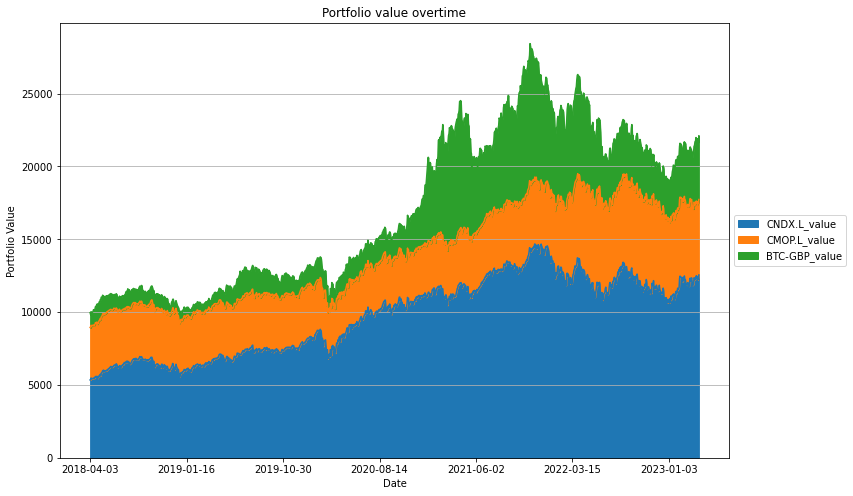

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

df[['CNDX.L_value', 'CMOP.L_value', 'BTC-GBP_value']].plot.area(ax=ax, stacked=True)

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.yaxis.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title("Portfolio value overtime")
plt.show()


In [32]:
# define a dictionary with asset class by ticker 

asset_class_value = {
               'CNDX.L_value': 'equity', 
               'CMOP.L_value': 'commodity', 
               'BTC-GBP_value': 'bitcoin'}

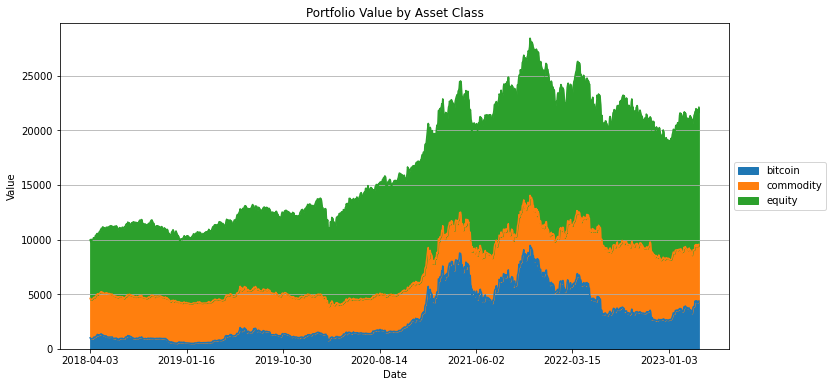

In [33]:
# group the data by asset class
grouped = df.groupby(asset_class_value, axis=1).sum()

# plot a stacked area chart
ax = grouped.plot.area(stacked=True, figsize=(12, 6))

# set chart title and labels
ax.set_title('Portfolio Value by Asset Class')
ax.set_xlabel('Date')
ax.set_ylabel('Value')

# add horizontal gridlines
ax.yaxis.grid(True)

# move the legend outside of the chart area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


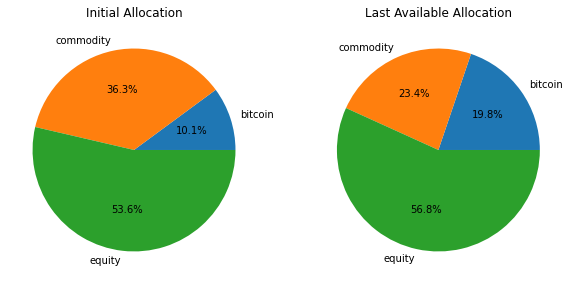

In [34]:
# get initial allocation
initial_alloc = df.iloc[0]
initial_alloc = initial_alloc.groupby(asset_class_value).sum()

# get last available allocation
last_alloc = df.iloc[-1]
last_alloc = last_alloc.groupby(asset_class_value).sum()

# create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the initial allocation pie chart
axs[0].pie(initial_alloc, labels=initial_alloc.index, autopct='%1.1f%%')
axs[0].set_title('Initial Allocation')

# plot the last allocation pie chart
axs[1].pie(last_alloc, labels=last_alloc.index, autopct='%1.1f%%')
axs[1].set_title('Last Available Allocation')

# display the plot
plt.show()


# Add risk-free rate data

In [35]:
import pandas_datareader as pdr

# Define the start and end dates
last_5_years = dt.date.today() - dt.timedelta(days=1825)
yesterday = dt.date.today()

# Pull the US 3-month T-bill rate from FRED
tbill_rate = pdr.DataReader('DGS3MO', 'fred', last_5_years, yesterday)

# Rename the column to 'tbill_rate'
tbill_rate = tbill_rate.rename(columns={'DGS3MO': 'tbill_rate'})

#format day column
tbill_rate.index = tbill_rate.index.strftime('%Y-%m-%d')

# Merge the tbill_rate dataframe with the original dataframe
df = pd.merge(df, tbill_rate, left_index=True, right_index=True, how='left')

df.tail(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares,CNDX.L_value,CMOP.L_value,BTC-GBP_value,tbill_rate
Date,,,,,,,,,,,,,
2023-03-29,588.595419,18.175,22114.345703,0.008873,0.81100,0.87901,21.0,286.0,0.189947,12360.503805,5198.05,4200.553337,4.8
2023-03-30,597.680498,18.110,23028.177734,0.010415,0.81211,0.88064,21.0,286.0,0.189947,12551.290468,5179.46,4374.132978,NaN


In [36]:
df['tbill_rate'].fillna(method='ffill', inplace=True)

# Continue analysis

In [37]:
# calculate total portfolio value

df['portfolio_total_value'] = df[[
 'CNDX.L_value',
 'CMOP.L_value',
 'BTC-GBP_value']].sum(axis=1)



In [38]:
df['portfolio_total_value'].tail(5)

Date
2023-03-24    21834.465664
2023-03-27    21904.008848
2023-03-28    21588.628422
2023-03-29    21759.107142
2023-03-30    22104.883446
Name: portfolio_total_value, dtype: float64

In [39]:
# calculate the change in portfolio total value 

df['portfolio_daily_returns'] = df['portfolio_total_value'].pct_change()*100

df['portfolio_daily_returns'].head(5)

Date
2018-04-03         NaN
2018-04-04   -1.270772
2018-04-05    1.938348
2018-04-06   -1.102923
2018-04-09    0.446191
Name: portfolio_daily_returns, dtype: float64

In [40]:
df.head(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares,CNDX.L_value,CMOP.L_value,BTC-GBP_value,tbill_rate,portfolio_total_value,portfolio_daily_returns
Date,,,,,,,,,,,,,,,
2018-04-03,254.429529,12.630,5300.426270,0.000000,0.71191,0.87509,21.0,286.0,0.189947,5343.020102,3612.18,1006.800000,1.75,9962.000102,NaN
2018-04-04,254.174967,12.495,4865.365234,-0.011832,0.71080,0.87273,21.0,286.0,0.189947,5337.674298,3573.57,924.161467,1.71,9835.405765,-1.270772


In [41]:
mean_daily_returns = df['portfolio_daily_returns'].mean()

std_daily_returns = df['portfolio_daily_returns'].std()

yearly_returns = (mean_daily_returns)*252

print(mean_daily_returns)
print(std_daily_returns)
print(yearly_returns)

0.07261786153297477
1.372044298838657
18.29970110630964


In [42]:
last_tbill_rate = df['tbill_rate'].iloc[-2]

print(last_tbill_rate)

sharpe_ratio = (yearly_returns-last_tbill_rate)/std_daily_returns

print(sharpe_ratio)

4.8
9.839114610028428


# Compare to other benchmarks

In [43]:
df.head(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares,CNDX.L_value,CMOP.L_value,BTC-GBP_value,tbill_rate,portfolio_total_value,portfolio_daily_returns
Date,,,,,,,,,,,,,,,
2018-04-03,254.429529,12.630,5300.426270,0.000000,0.71191,0.87509,21.0,286.0,0.189947,5343.020102,3612.18,1006.800000,1.75,9962.000102,NaN
2018-04-04,254.174967,12.495,4865.365234,-0.011832,0.71080,0.87273,21.0,286.0,0.189947,5337.674298,3573.57,924.161467,1.71,9835.405765,-1.270772


<AxesSubplot:xlabel='Date'>

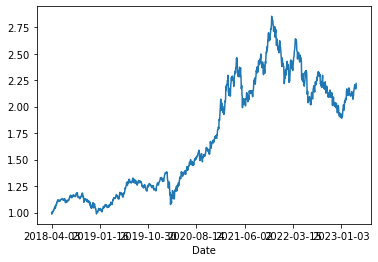

In [44]:
# calculate the portfolio cumulative returns 

df['portfolio_cumulative_returns'] = (1 + df['portfolio_total_value'].pct_change()).cumprod()

df['portfolio_cumulative_returns'].plot()

In [45]:
# download SPY data and compare 

tickers = ['SPY']

# use a for loop to fetch the "Close" price data for each ticker
dfs = []
for ticker in tickers:
    t = yf.Ticker(ticker)
    data = t.history(start=last_5_years, end=yesterday)
    data = pd.DataFrame(data['Close'])
    data.columns = [ticker]
    data.index = data.index.strftime('%Y-%m-%d')
    dfs.append(data)

# Merge dataframes using index date
df_spy = dfs[0]
for i in range(1, len(dfs)):
    df_spy = pd.merge(df, dfs[i], how='outer', left_index=True, right_index=True)

# Rename the columns with the tickers
df_spy.columns = tickers

df_spy.head(5)

,SPY
Date,
2018-04-02,236.436142
2018-04-03,239.466537
2018-04-04,242.028580
2018-04-05,243.938660
2018-04-06,238.502319


In [47]:
# merge spy data with existing df

df = pd.merge(df, df_spy, how='left', left_index=True, right_index=True)

df.head(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares,CNDX.L_value,CMOP.L_value,BTC-GBP_value,tbill_rate,portfolio_total_value,portfolio_daily_returns,portfolio_cumulative_returns,SPY
Date,,,,,,,,,,,,,,,,,
2018-04-03,254.429529,12.630,5300.426270,0.000000,0.71191,0.87509,21.0,286.0,0.189947,5343.020102,3612.18,1006.800000,1.75,9962.000102,NaN,NaN,239.466537
2018-04-04,254.174967,12.495,4865.365234,-0.011832,0.71080,0.87273,21.0,286.0,0.189947,5337.674298,3573.57,924.161467,1.71,9835.405765,-1.270772,0.987292,242.028580


In [50]:
# calculate spy returns 

df['spy_cumulative_returns'] = (1 + df['SPY'].pct_change()).cumprod()

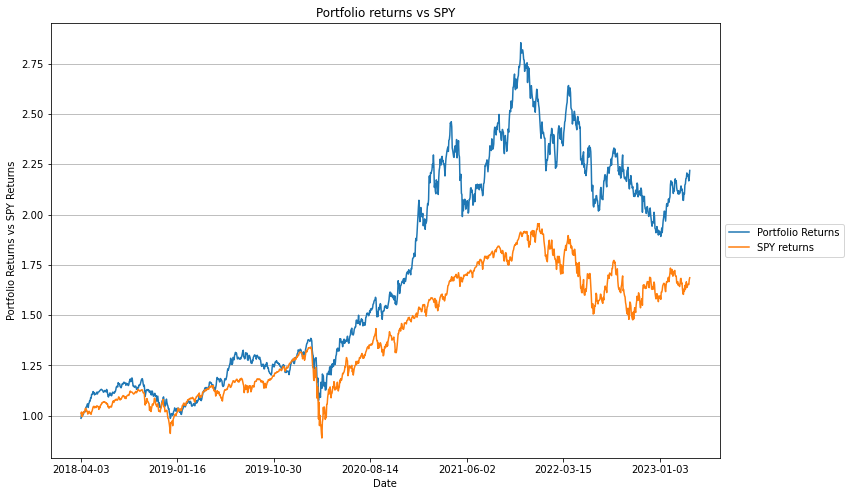

In [58]:
#chart portfolio returns vs SPY returns

fig, ax = plt.subplots(figsize=(12, 8))

labels = ['Portfolio Returns', 'SPY returns']

df[['portfolio_cumulative_returns', 'spy_cumulative_returns']].plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Returns vs SPY Returns')
ax.yaxis.grid(True)
ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title("Portfolio returns vs SPY")
plt.show()

# Add more benchmarks

In [70]:
# download SPY data and compare 

tickers = ['QQQ']

# use a for loop to fetch the "Close" price data for each ticker
dfs = []
for ticker in tickers:
    t = yf.Ticker(ticker)
    data = t.history(start=last_5_years, end=yesterday)
    data = pd.DataFrame(data['Close'])
    data.columns = [ticker]
    data.index = data.index.strftime('%Y-%m-%d')
    dfs.append(data)

# Merge dataframes using index date
df_qqq = dfs[0]
for i in range(1, len(dfs)):
    df_qqq = pd.merge(df, dfs[i], how='outer', left_index=True, right_index=True)

# Rename the columns with the tickers
df_qqq.columns = tickers

df_qqq.head(5)

,QQQ
Date,
2018-04-02,150.255463
2018-04-03,151.946381
2018-04-04,154.342636
2018-04-05,155.221832
2018-04-06,151.337692


In [71]:
# merge spy data with existing df

df = pd.merge(df, df_qqq, how='left', left_index=True, right_index=True)

df.head(2)

,CNDX.L,CMOP.L,BTC-GBP,portfolio_returns,USDGBP,EURGBP,CNDX.L_shares,CMOP.L_shares,BTC-GBP_shares,CNDX.L_value,CMOP.L_value,BTC-GBP_value,tbill_rate,portfolio_total_value,portfolio_daily_returns,portfolio_cumulative_returns,SPY,spy_cumulative_returns,QQQ
Date,,,,,,,,,,,,,,,,,,,
2018-04-03,254.429529,12.630,5300.426270,0.000000,0.71191,0.87509,21.0,286.0,0.189947,5343.020102,3612.18,1006.800000,1.75,9962.000102,NaN,NaN,239.466537,NaN,151.946381
2018-04-04,254.174967,12.495,4865.365234,-0.011832,0.71080,0.87273,21.0,286.0,0.189947,5337.674298,3573.57,924.161467,1.71,9835.405765,-1.270772,0.987292,242.028580,1.010699,154.342636


In [72]:
# calculate spy returns 

df['qqq_cumulative_returns'] = (1 + df['QQQ'].pct_change()).cumprod()

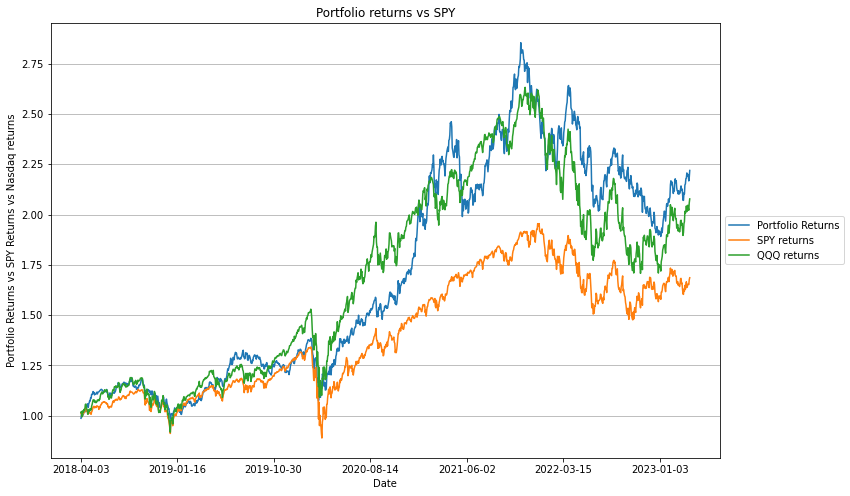

In [75]:
#chart portfolio returns vs SPY returns

fig, ax = plt.subplots(figsize=(12, 8))

labels = ['Portfolio Returns', 'SPY returns', 'QQQ returns']

df[['portfolio_cumulative_returns', 'spy_cumulative_returns', 'qqq_cumulative_returns']].plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Returns vs SPY Returns vs Nasdaq returns')
ax.yaxis.grid(True)
ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title("Portfolio returns vs SPY")
plt.show()